# PHÁT BIỂU BÀI TOÁN

## 1. Đề tài

**Phân tích phân khúc giá đồng hồ dựa trên các thông số kỹ thuật, thương hiệu và đặc tính**

## 2. Nguồn dữ liệu

-   **Nguồn**: Thu thập từ website Jomashop.com bằng phương pháp web scraping
-   **Công cụ**: Selenium, BeautifulSoup, Pandas, ThreadPoolExecutor
-   **Quy mô**: 13,884 mẫu đồng hồ với 59 thuộc tính

## 3. Input

-   Các thông số kỹ thuật đồng hồ:
    -   Chất liệu vỏ (Case Material)
    -   Chất liệu dây đeo (Band Material)
    -   Mặt sau vỏ (Case Back)
    -   Chất liệu vành (Bezel Material)
    -   Thương hiệu (Brand)
    -   Giới tính (Gender)
    -   Bộ máy (Movement)
    -   Mặt kính (Crystal)
    -   Kim đồng hồ (Hands)
    -   Đánh dấu mặt số (Dial Marker)
    -   Và nhiều thuộc tính khác

## 4. Output

-   **Bài toán phân cụm**: Các nhóm (cluster) tự nhiên của đồng hồ dựa trên đặc tính kỹ thuật
-   **Bài toán phân loại**: Dự đoán phân khúc giá (0-4) dựa trên đặc tính kỹ thuật của đồng hồ:
    -   Phân khúc 0: Giá rẻ (Budget) - < $1,000
    -   Phân khúc 1: Phổ thông (Affordable) - $1,000 - $9,999
    -   Phân khúc 2: Trung cấp (Mid-Range) - $10,000 - $29,999
    -   Phân khúc 3: Cao cấp (Premium) - $30,000 - $99,999
    -   Phân khúc 4: Siêu cao cấp (Luxury) - ≥ $100,000

## 5. Thành viên tham gia

**KHDL 22.13 - Nhóm 10**

-   Trương Vũ Linh
-   Hoàng Văn Đạt
-   Đỗ Văn Tuấn

## 6. Bài toán cần giải quyết

### 6.1. Bài toán phân cụm (Unsupervised Learning)

-   **Mục tiêu**: Khám phá và nhận diện các nhóm tự nhiên trong dữ liệu đồng hồ
-   **Phương pháp**: Sử dụng thuật toán phân cụm.
-   **Ứng dụng**: Hiểu cấu trúc thị trường đồng hồ, định vị sản phẩm, phân tích xu hướng thiết kế

### 6.2. Bài toán phân loại (Supervised Learning)

-   **Mục tiêu**: Dự đoán phân khúc giá của đồng hồ dựa trên các đặc tính kỹ thuật
-   **Phương pháp**: Sử dụng các thuật toán học máy.
-   **Ứng dụng**: Định giá sản phẩm, phát hiện giá bất thường, hỗ trợ ra quyết định mua sắm


# 1. Craw Clock Products from Jomashop


In [ ]:
# =====================================================================
# IMPORTS - Essential libraries for web scraping and data processing
# =====================================================================
import os                                 # File and directory operations
import logging                            # Structured logging capabilities
import random                             # Random number generation (for page sampling)
import time                               # Time-related functions (for delays)
import csv                                # CSV file reading/writing
import pandas as pd                       # Data manipulation and analysis
from concurrent.futures import ThreadPoolExecutor, as_completed  # Parallel execution
from selenium import webdriver            # Browser automation
from urllib.parse import urljoin          # URL manipulation
from selenium.webdriver.chrome.service import Service  # Chrome driver service
from selenium.webdriver.common.by import By           # Element locator strategies
from selenium.webdriver.support.ui import WebDriverWait  # Explicit waiting
from selenium.webdriver.support import expected_conditions as EC  # Wait conditions
from selenium.common.exceptions import NoSuchElementException  # Exception handling
from webdriver_manager.chrome import ChromeDriverManager  # Auto-downloads chromedriver
from webdriver_manager.core import driver_cache  # Driver caching
from tqdm import tqdm                     # Progress bar visualization
import requests                           # HTTP requests
from bs4 import BeautifulSoup             # HTML parsing

# =====================================================================
# CONFIGURATION - Constants and parameters for the scraping process
# =====================================================================
BASE_URL = "https://www.jomashop.com/watches.html?p={}"  # URL template with page placeholder
BATCH_SIZE = 10            # Number of pages to process in a single batch
MAX_WORKERS = 3            # Maximum number of concurrent threads
OUTPUT_FILE = "../data/products.csv"  # Final output file path
LINKS_FILE = "../data/links.csv"      # Intermediate file to store product URLs
MAX_RETRIES = 2            # Maximum number of retry attempts for failed operations
RETRY_DELAY = 1            # Seconds to wait between retries
DRIVER_SETUP_RETRIES = 2   # Maximum attempts for driver setup
DRIVER_SETUP_DELAY = 3     # Seconds to wait between driver setup attempts
IMPLICIT_WAIT = 3.0        # Seconds that Selenium will wait for elements to appear
SCROLL_PAUSE = 1.0         # Seconds to pause between page scrolls
HEADERS = {                # HTTP headers to mimic a real browser
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/114.0.0.0 Safari/537.36"
    )
}

# =====================================================================
# LOGGING SETUP - Configure logging to track the scraping process
# =====================================================================
logging.basicConfig(
    level=logging.INFO,                             # Set minimum log level
    format="%(asctime)s - %(levelname)s - %(message)s",  # Log format with timestamp
    handlers=[logging.StreamHandler()]              # Output logs to console
)
logger = logging.getLogger(__name__)                # Get logger instance

# =====================================================================
# DRIVER SETUP - Initialize and configure the browser driver
# =====================================================================
def setup_driver_service():
    """
    Download or fetch ChromeDriver binary with retry logic.
    
    This function attempts to install/retrieve the ChromeDriver up to 
    DRIVER_SETUP_RETRIES times. This adds resilience against network issues
    or temporary failures in the ChromeDriver download process.
    
    Returns:
        Service: The Chrome driver service object
        
    Raises:
        RuntimeError: If all driver setup attempts fail
    """
    for attempt in range(1, DRIVER_SETUP_RETRIES + 1):
        try:
            # Attempt to download or retrieve the ChromeDriver
            driver_path = ChromeDriverManager().install()
            return Service(driver_path)
        except Exception as e:
            # Log warning and retry after delay
            logger.warning(f"Driver setup attempt {attempt} failed: {e}")
            time.sleep(DRIVER_SETUP_DELAY)
    
    # If all attempts fail, log error and raise exception
    logger.error(f"All {DRIVER_SETUP_RETRIES} chrome driver setups failed")
    raise RuntimeError("Unable to install ChromeDriver")

def init_driver(headless: bool = True) -> webdriver.Chrome:
    """
    Initialize and configure a Chrome WebDriver instance.
    
    This function sets up a Chrome browser with appropriate options for web scraping,
    including headless mode (no visible browser window) and other performance settings.
    
    Args:
        headless (bool): Whether to run Chrome in headless mode (default: True)
        
    Returns:
        webdriver.Chrome: Configured Chrome WebDriver instance
    """
    # Configure Chrome options
    options = webdriver.ChromeOptions()
    if headless:
        options.add_argument("--headless")  # Run without visible browser window
    options.add_argument("--no-sandbox")    # Bypass OS security model
    options.add_argument("--disable-dev-shm-usage")  # Overcome limited resource problems
    
    # Initialize the driver with the configured service and options
    service = setup_driver_service()
    driver = webdriver.Chrome(service=service, options=options)
    driver.implicitly_wait(IMPLICIT_WAIT)  # Set implicit wait time for all operations
    return driver

# =====================================================================
# PAGE INTERACTION - Functions to interact with and navigate web pages
# =====================================================================
def scroll_down_slowly(driver: webdriver.Chrome, pause_time: float = 2.0, max_scrolls: int = 30) -> None:
    """
    Gradually scroll down a page to load lazy-loaded content.
    
    Many modern websites use lazy loading to improve performance, where content
    (like product listings) is only loaded when scrolled into view. This function
    simulates a human gradually scrolling down the page to ensure all content loads.
    
    Args:
        driver (webdriver.Chrome): The WebDriver instance
        pause_time (float): Time to pause between scrolls in seconds (default: 2.0)
        max_scrolls (int): Maximum number of scroll operations (default: 30)
    """
    print("Scrolling down the page...")
    scroll_count = 0

    while scroll_count < max_scrolls:
        # Scroll down by 4000 pixels
        driver.execute_script("window.scrollBy(0, 4000);")
        time.sleep(pause_time)  # Allow time for content to load

        # Get current scroll position and total page height
        scroll_height = driver.execute_script("return document.body.scrollHeight")
        scroll_position = driver.execute_script("return window.scrollY + window.innerHeight")

        # Log scrolling progress
        print(f"Scroll #{scroll_count + 1} | Scroll position: {scroll_position:.0f} | Total height: {scroll_height:.0f}")

        # If we've reached the bottom of the page, stop scrolling
        if scroll_position >= scroll_height:
            print("Reached bottom of the page.")
            break

        scroll_count += 1

    # Log if we hit the maximum scroll limit
    if scroll_count >= max_scrolls:
        print("Reached max scroll limit.")

# =====================================================================
# LINK EXTRACTION - Functions to extract product links from catalog pages
# =====================================================================
def find_product_link(prod_element, max_strategy_retries=2):
    """
    Extract a product URL from a product element using multiple strategies.
    
    This function employs a resilient approach using multiple extraction methods
    to find product links. This makes the scraper more robust against website changes
    since if one method fails, it will try others.
    
    The function tries 7 different strategies in order of preference:
    1. data-scroll-target attribute on .productItemBlock
    2. CSS selector for anchor tags
    3. productImg-link class
    4. productName-link class
    5. XPath targeting anchors in productItemBlock
    6. JavaScript querySelector
    7. Fallback: scan all <a> tags for valid URLs
    
    Args:
        prod_element: The WebElement containing product information
        max_strategy_retries (int): Number of times to retry each strategy (default: 2)
        
    Returns:
        str or None: The extracted product URL or None if all strategies fail
    """
    # Define extraction strategies from most to least preferred
    strategies = [
        # 1. data-scroll-target attribute on .productItemBlock
        lambda el: el.find_element(By.CLASS_NAME, "productItemBlock").get_attribute("data-scroll-target"),
        # 2. CSS selector
        lambda el: el.find_element(By.CSS_SELECTOR, ".productItemBlock a").get_attribute("href"),
        # 3. className productImg-link
        lambda el: el.find_element(By.CLASS_NAME, "productImg-link").get_attribute("href"),
        # 4. className productName-link
        lambda el: el.find_element(By.CLASS_NAME, "productName-link").get_attribute("href"),
        # 5. XPath
        lambda el: el.find_element(By.XPATH, ".//div[contains(@class,'productItemBlock')]//a").get_attribute("href"),
        # 6. JS querySelector
        lambda el: el.parent.execute_script(
            "return arguments[0].querySelector('.productItemBlock a').href;", el),
        # 7. fallback: scan all <a> tags
        lambda el: next(
            (a.get_attribute("href") for a in el.find_elements(By.TAG_NAME, "a")
             if a.get_attribute("href")), None
        ),
    ]

    # Try each strategy with retry logic
    last_exception = None
    for strat_idx, strat in enumerate(strategies, start=1):
        for attempt in range(1, max_strategy_retries + 1):
            try:
                # Execute the current strategy
                href = strat(prod_element)
                if href:
                    # Handle relative URLs by joining with base URL
                    if href.startswith("/"):
                        href = urljoin(BASE_URL, href)
                    print(f"Strategy #{strat_idx} succeeded on attempt {attempt}: {href}")
                    return href
                else:
                    raise NoSuchElementException("Empty href")
            except Exception as e:
                last_exception = e
                print(f"  Strategy #{strat_idx} attempt {attempt} failed: {e}")
                time.sleep(0.3)  # Brief delay before retry
        print(f"→ Strategy #{strat_idx} exhausted, chuyển sang chiến lược tiếp theo.")
    
    # If all strategies fail, log the failure and return None
    print(f"Tất cả chiến lược đều thất bại cho phần tử: {last_exception}")
    return None


def extract_product_links(page: int, max_retries: int = MAX_RETRIES) -> list:
    """
    Extract all product links from a catalog page.
    
    This function navigates to a specific page number in the catalog, scrolls 
    to load all products, and extracts product links using the multi-strategy
    approach. It includes retry logic for resilience.
    
    Args:
        page (int): The catalog page number to scrape
        max_retries (int): Maximum number of retry attempts for the entire process
        
    Returns:
        list: List of product URLs extracted from the page
    """
    logger.info(f"Extracting links from page {page}")
    url = BASE_URL.format(page)  # Generate the full URL with page number
    print(f"Fetching page {page}: {url}")

    # Retry the entire extraction process if needed
    for attempt in range(1, max_retries + 1):
        try:
            # Initialize browser and navigate to page
            driver = init_driver()
            driver.get(url)

            # Scroll to ensure all products load
            print("Scrolling to load products...")
            scroll_down_slowly(driver)

            # Wait for product elements to be present
            WebDriverWait(driver, IMPLICIT_WAIT).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, "productItem"))
            )
            
            # Find all product elements
            products = driver.find_elements(By.CLASS_NAME, "productItem")
            print(f"  Found {len(products)} product items on page {page}")

            # Extract links from each product element
            links = []
            for idx, prod in enumerate(products, start=1):
                href = find_product_link(prod)
                if href:
                    links.append(href)
                else:
                    logger.error(f"Page {page}, product #{idx}: không lấy được link.")

            logger.info(f"Page {page}: extracted {len(links)} links on attempt {attempt}")
            return links

        except Exception as e:
            # Log and retry after delay
            logger.warning(f"Attempt {attempt} failed for page {page}: {e}")
            time.sleep(RETRY_DELAY)
        finally:
            # Always ensure the driver is closed to prevent resource leaks
            driver.quit()

    # If all attempts fail, log error and return empty list
    logger.error(f"All {max_retries} attempts failed for page {page}")
    return []

# =====================================================================
# PRODUCT DETAIL SCRAPING - Extract detailed product information
# =====================================================================
def scrape_product_with_retry(url: str, max_retries: int = MAX_RETRIES) -> dict:
    """
    Scrape detailed information from a product page with retry logic.
    
    This function visits a product page and extracts:
    1. The product price
    2. All specification details (label-value pairs)
    
    It includes several layers of error handling:
    - Retry for driver initialization failures
    - Graceful handling of UI elements that may not be present
    - Retry for page loading or scraping failures
    
    Args:
        url (str): The product page URL
        max_retries (int): Maximum number of retry attempts
        
    Returns:
        dict: Product details with URL, price, and specifications
              or error information if all attempts fail
    """
    # Retry the entire scraping process if needed
    for attempt in range(1, max_retries + 1):
        try:
            # Initialize browser (with separate try-except for driver initialization)
            driver = init_driver()
        except Exception as e:
            logger.error(f"{url}: driver init failed: {e}")
            time.sleep(RETRY_DELAY)
            continue  # Skip to next attempt if driver fails
            
        try:
            # Navigate to product page
            driver.get(url)
            
            # Try to click "Show More" button if present (wrapped in try-except as it may not exist)
            try:
                more_btn = WebDriverWait(driver, 5).until(
                    EC.element_to_be_clickable((By.CLASS_NAME, "show-text"))
                )
                driver.execute_script("arguments[0].click();", more_btn)
            except Exception:
                pass  # Continue if button not found or not clickable
                
            # Wait for product details to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, "more-detail-content"))
            )
            
            # Extract price
            price = driver.find_element(By.CLASS_NAME, "now-price").text.strip()
            
            # Extract all specification details
            specs = driver.find_elements(By.CLASS_NAME, "more-detail-content")
            record = {"URL": url, "Price": price}
            
            # Process each specification (label-value pair)
            for spec in specs:
                try:
                    # Extract and format label (replace spaces with underscores for CSV compatibility)
                    label = spec.find_element(By.CLASS_NAME, "more-label").text.strip().replace(' ', '_')
                    # Extract value
                    value = spec.find_element(By.CLASS_NAME, "more-value").text.strip()
                    record[label] = value
                except Exception:
                    continue  # Skip this spec if extraction fails
                    
            logger.info(f"Scraped details for {url} on attempt {attempt}")
            return record
            
        except Exception as e:
            # Log and retry after delay
            logger.error(f"Attempt {attempt} failed for {url}: {e}")
            time.sleep(RETRY_DELAY)
        finally:
            # Always ensure the driver is closed
            driver.quit()
            
    # If all attempts fail, return error record
    logger.error(f"All {max_retries} attempts failed for {url}")
    return {"URL": url, "Error": "Failed after retries"}

# =====================================================================
# DATA PERSISTENCE - Save scraped data to CSV files
# =====================================================================
def save_to_csv(record: dict, filename: str = "output.csv") -> None:
    """
    Save a product record to a CSV file with data validation.
    
    This function:
    1. Validates essential data (price)
    2. Cleans the data (removes unnamed columns, empty columns)
    3. Handles file creation or appending to existing file
    4. Logs the operation
    
    Args:
        record (dict): Product data dictionary to save
        filename (str): Path to the CSV file
    """
    # Validate price (don't save records with invalid prices)
    price = record.get('Price')
    if price in [None, '', 'null', 'None'] or pd.isna(price):
        logger.error(f"Invalid price: {price} for URL: {record.get('URL')}")
        return

    # Create new DataFrame and clean it
    df_new = pd.DataFrame([record])
    df_new = df_new.loc[:, ~df_new.columns.str.contains('^Unnamed')]  # Remove unnamed columns
    df_new = df_new.dropna(axis=1, how='all')  # Remove columns with all NaN values

    # Handle file existence (create new or append to existing)
    if os.path.exists(filename):
        # Read and clean existing data
        df_old = pd.read_csv(filename)
        df_old = df_old.loc[:, ~df_old.columns.str.contains('^Unnamed')]
        # Combine old and new data
        df = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df = df_new

    # Write data back to file
    df.to_csv(filename, index=False)
    logger.info(f"Saved record to {filename}: {record}")

# =====================================================================
# MAIN PROCESSING - Orchestrate the complete scraping workflow
# =====================================================================
def main():
    """
    Main function to orchestrate the web scraping process.
    
    The process has two main phases:
    1. Link extraction (commented out as already completed)
       - Select random catalog pages
       - Process pages in batches for efficiency
       - Extract product links in parallel
       - Save links to CSV
       
    2. Product detail scraping (active)
       - Read previously collected links from CSV
       - Scrape product details in parallel
       - Save each product's data as it's completed
    """
    # # Step 1: Extract links with retry and progress bars
    # # This section is commented out as it was already completed in a previous run
    # pages = random.sample(range(1, 500), 912)  # Randomly select 912 pages from range 1-500
    # all_links = []
    # batches = [pages[i:i + BATCH_SIZE] for i in range(0, len(pages), BATCH_SIZE)]  # Split into batches
    # for batch_num, batch in enumerate(batches, start=1):
    #     logger.info(f"Starting link batch {batch_num}/{len(batches)}: {batch}")
    #     with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    #         futures = {executor.submit(extract_product_links, p): p for p in batch}
    #         for future in tqdm(as_completed(futures), total=len(futures), desc=f"Links batch {batch_num}"):
    #             page = futures[future]
    #             links = future.result()
    #             if links and len(links) > 0:
    #                 logger.info(f"Page {page}: found {len(links)} links")
    #                 all_links.extend(links)
    #             else:
    #                 logger.warning(f"No links on page {page} after retries")
    #     logger.info(f"Completed link batch {batch_num}/{len(batches)}")

    # pd.DataFrame({"Product_URL": all_links}).to_csv(LINKS_FILE, index=False)
    # logger.info(f"Total links collected: {len(all_links)}")
    
    # Step 2: Scrape product details in parallel with retry
    # Read links from previously saved CSV file (starting from index 29000)
    df_links = pd.read_csv(LINKS_FILE)
    all_links = df_links["Product_URL"].tolist()[29000:]  # Continue from link #29000
    
    # Log the start of detail scraping
    logger.info(f"Starting detail scraping for {len(all_links)} products with {MAX_WORKERS} threads")
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Submit all scraping tasks to the executor
        futures = [executor.submit(scrape_product_with_retry, url) for url in all_links]
        
        # Process results as they complete (doesn't wait for all to finish)
        for future in tqdm(as_completed(futures), total=len(futures), desc="Scraping products"):
            record = future.result()
            save_to_csv(record, "../data/products2.csv")
            
    logger.info("Scraping complete.")

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
# Merge 2 CSV files
def merge_csv_files(file1: str, file2: str, output_file: str) -> None:
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    merged_df = pd.concat([df1, df2], ignore_index=True)
    merged_df.to_csv(output_file, index=False)
    print(f"Merged {file1} and {file2} into {output_file}")

merge_csv_files("../data/raw_data.csv", "../data/products2_dat.csv", "../data/raw_data.csv")

Merged ../data/merged_products.csv and ../data/products2_dat.csv into ../data/merged_products.csv


C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\3195825321.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Type", y="Count", data=size_df, palette="viridis")


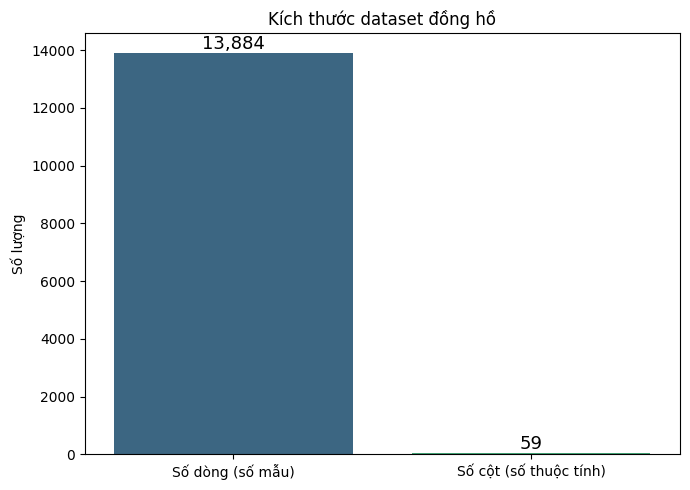

Tổng số dòng (số mẫu): 13,884
Tổng số cột (số thuộc tính): 59


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
df = pd.read_csv("../data/raw_data.csv")

# Thông tin kích thước
num_rows = df.shape[0]
num_cols = df.shape[1]

# Tạo DataFrame cho trực quan
size_df = pd.DataFrame({
    "Type": ["Số dòng (số mẫu)", "Số cột (số thuộc tính)"],
    "Count": [num_rows, num_cols]
})

# Vẽ biểu đồ
plt.figure(figsize=(7,5))
ax = sns.barplot(x="Type", y="Count", data=size_df, palette="viridis")
plt.title("Kích thước dataset đồng hồ")
plt.ylabel("Số lượng")
plt.xlabel("")
for i, v in enumerate(size_df["Count"]):
    ax.text(i, v + max(size_df["Count"])*0.01, f"{v:,}", ha='center', fontsize=13)
plt.tight_layout()
plt.show()

print(f"Tổng số dòng (số mẫu): {num_rows:,}")
print(f"Tổng số cột (số thuộc tính): {num_cols:,}")


C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")


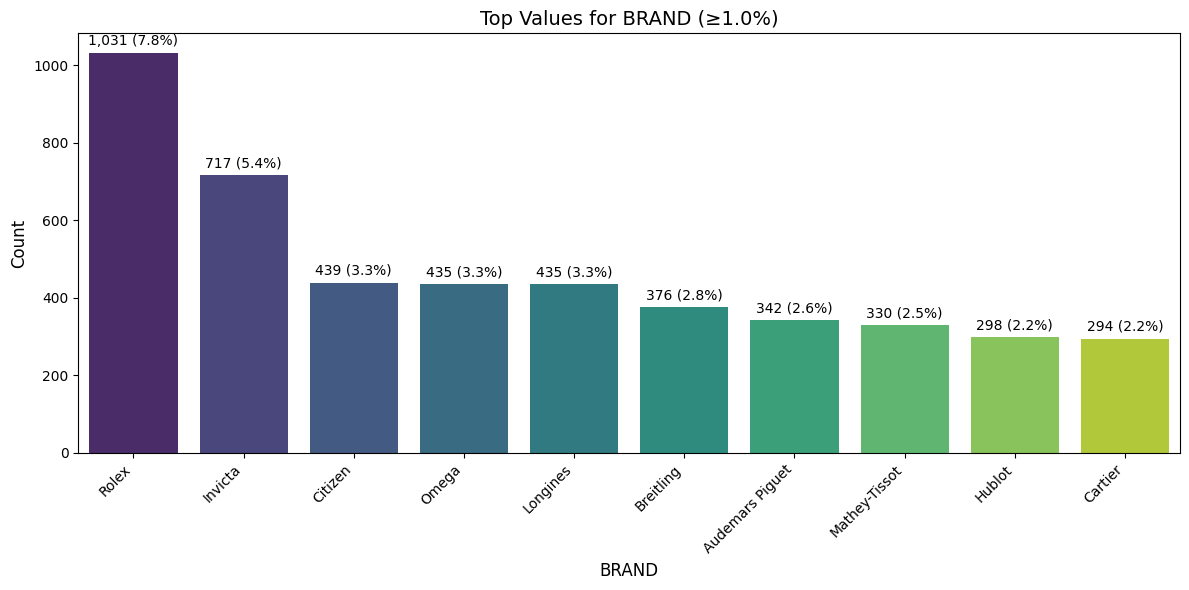

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")


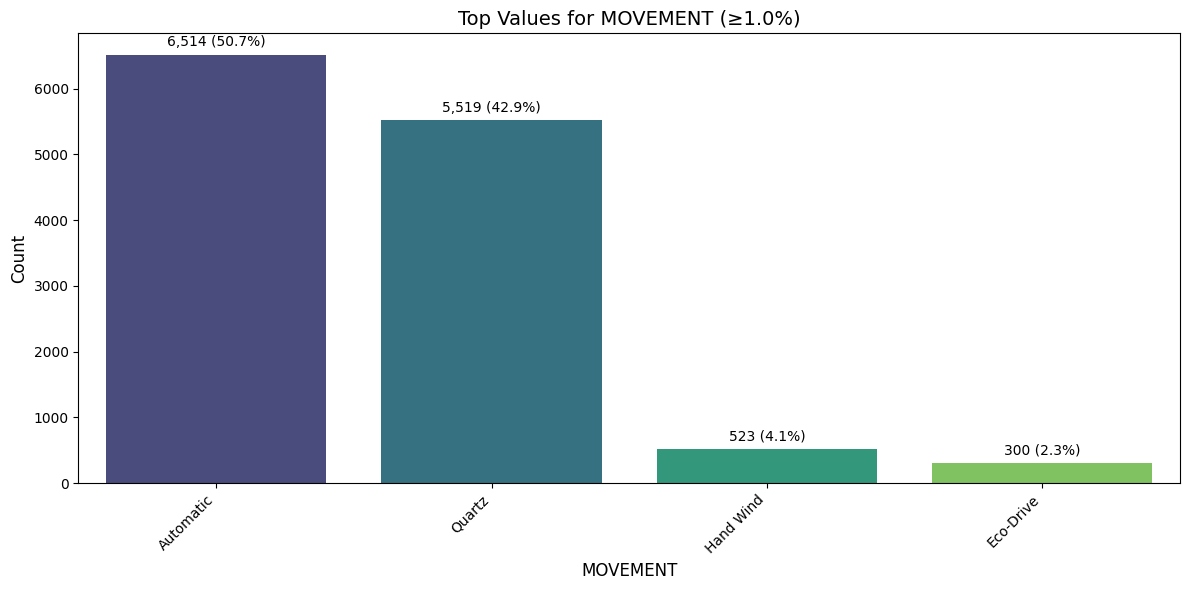

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")


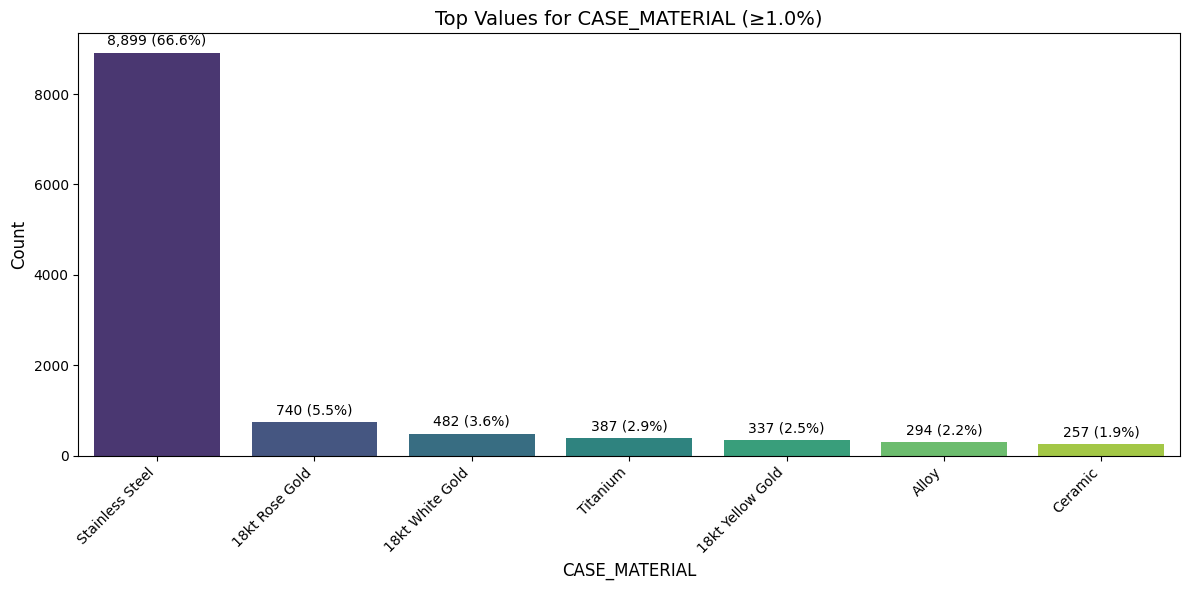

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")


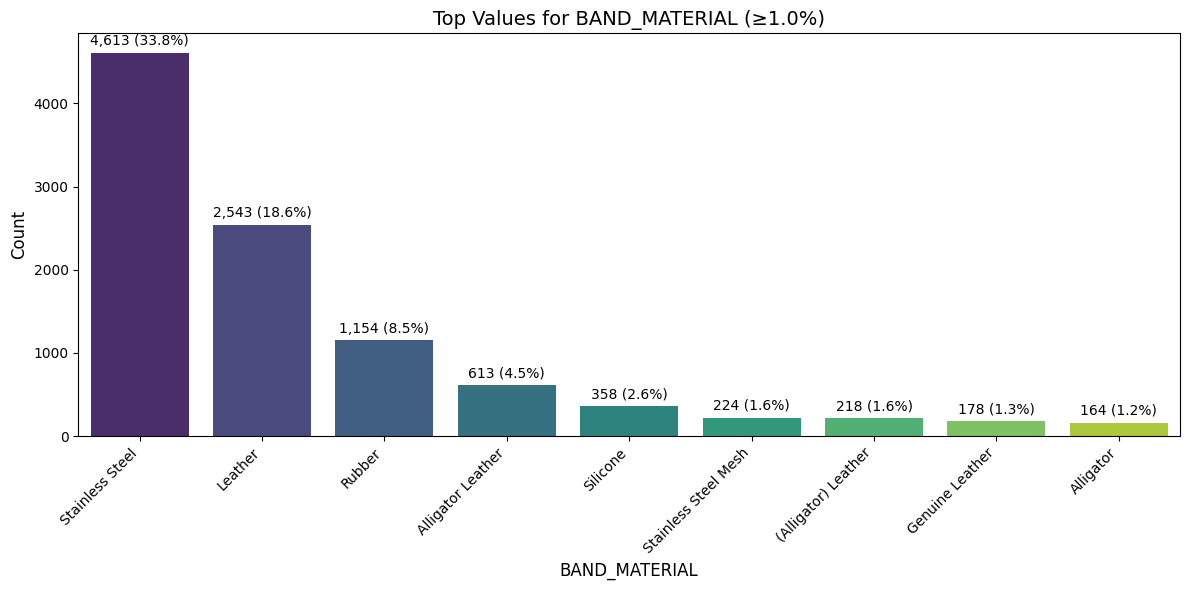

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")


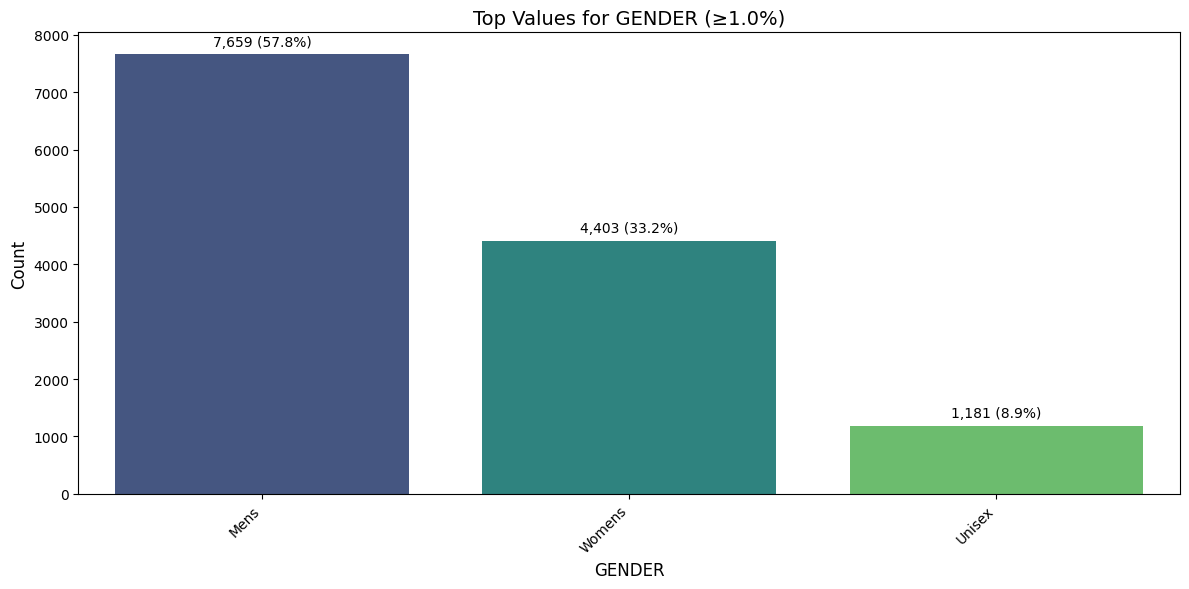

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")


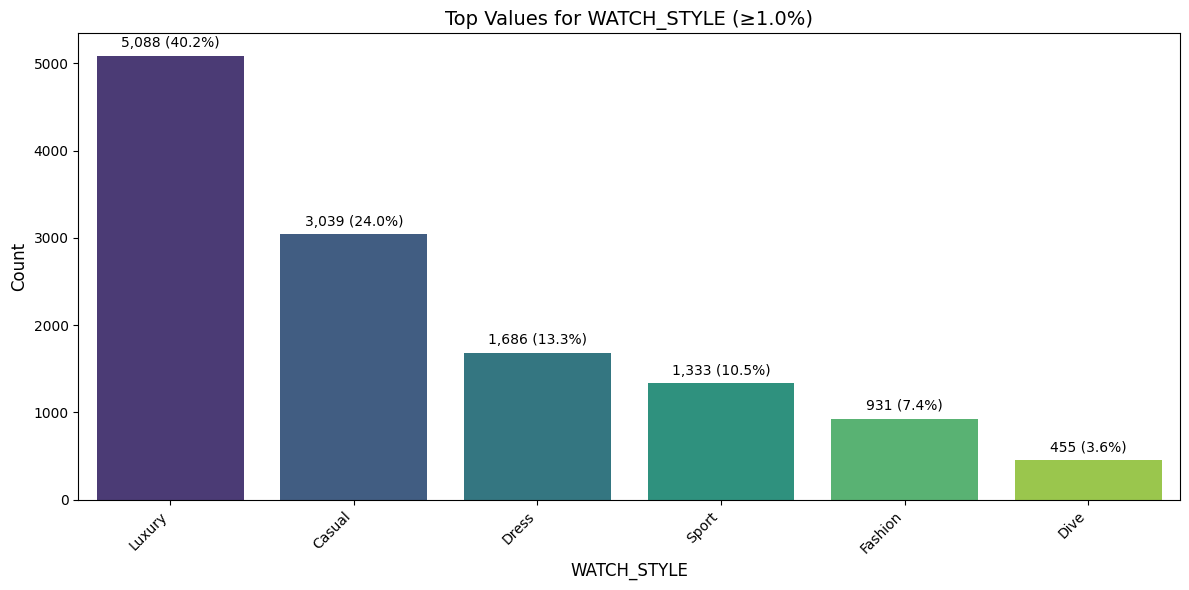

Total number of columns: 60
Columns with missing values: 59

Top 10 columns with highest percentage of missing values:
LAUNCH_YEAR                99.992797
CLOSURE_TYPE               99.942380
MATERIAL                   99.913570
CONDITION_DESCRIPTION      99.891962
SIZE_INFO                  99.870354
YEAR                       98.573898
CASE_COLOR                 98.213771
COMMENTS                   97.147796
BRAND_TYPE                 95.592048
PREOWNED_ITEM_CONDITION    94.706137
dtype: float64


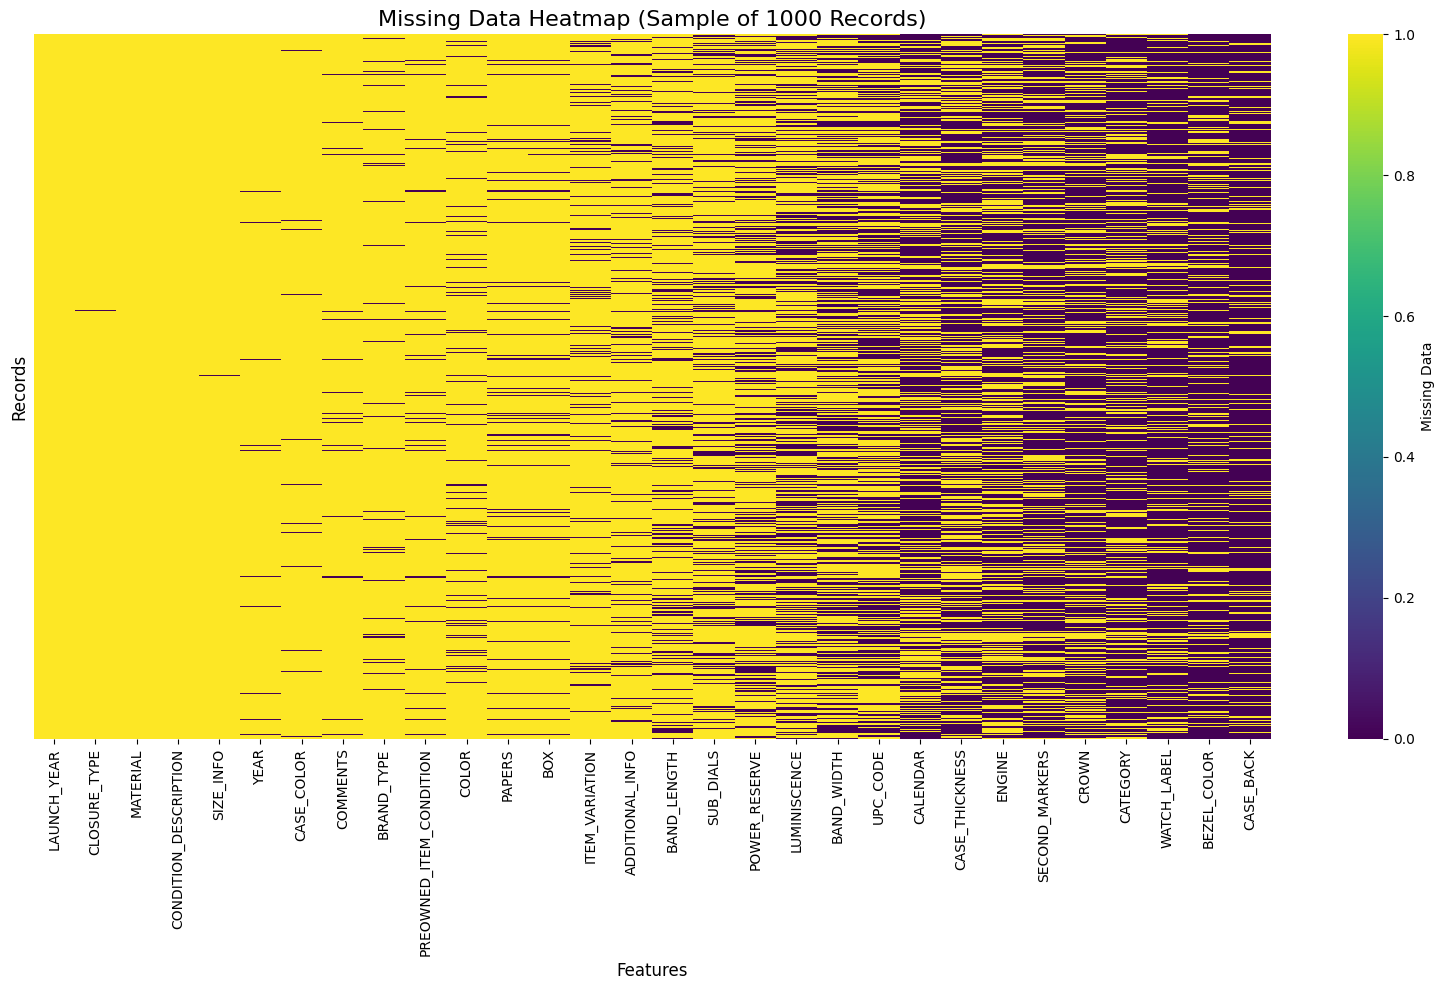


Price Statistics:
Min: $6.00
Max: $6,555,000.00
Mean: $16,458.32
Median: $1,094.99
Count: 13,798 (out of 13,884 records)


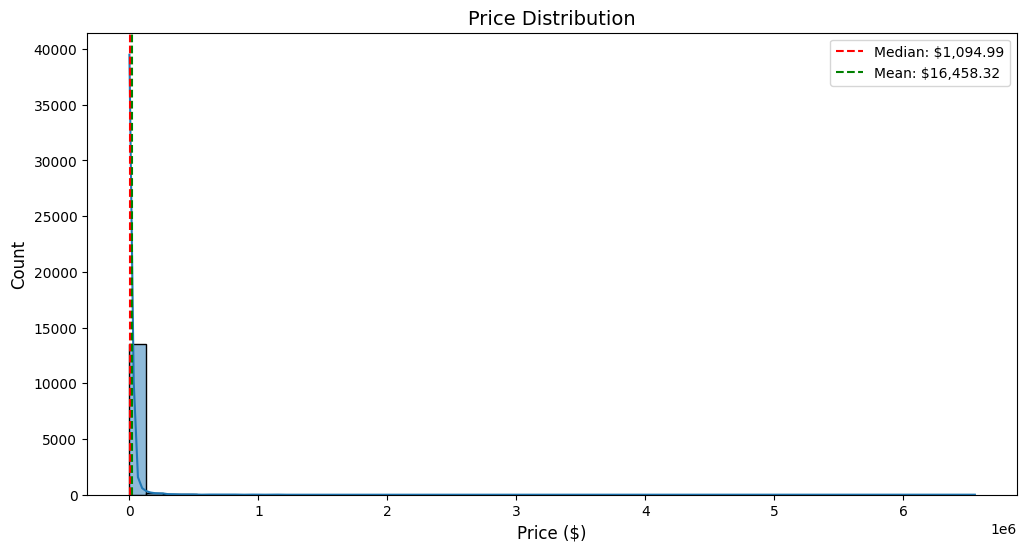

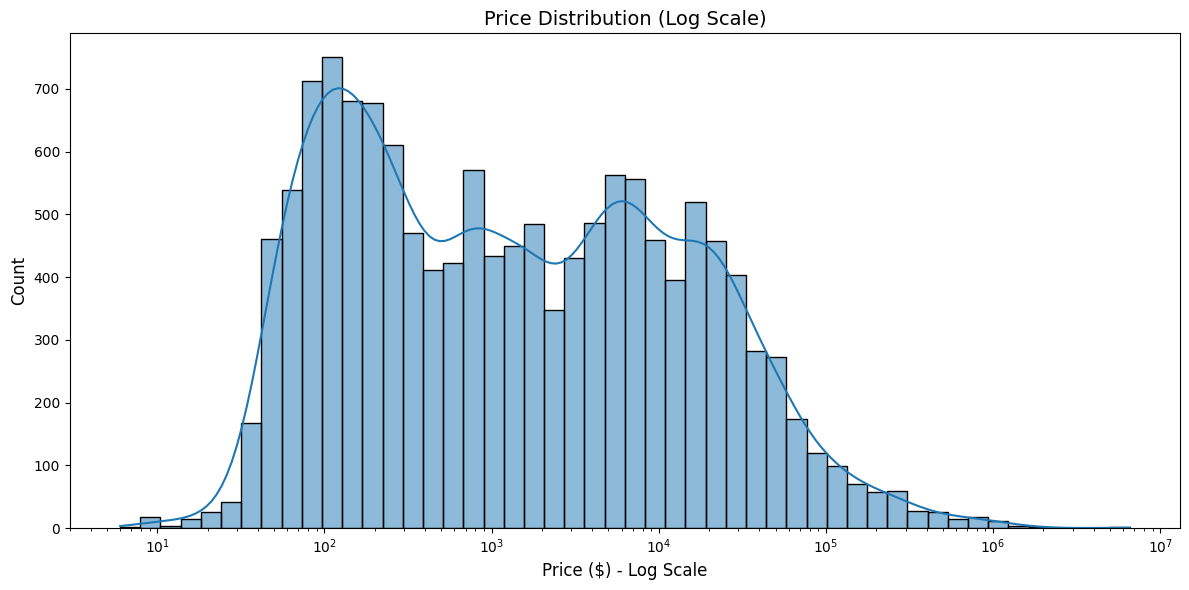

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BRAND', y='Price_Numeric', data=brand_df, palette='viridis')


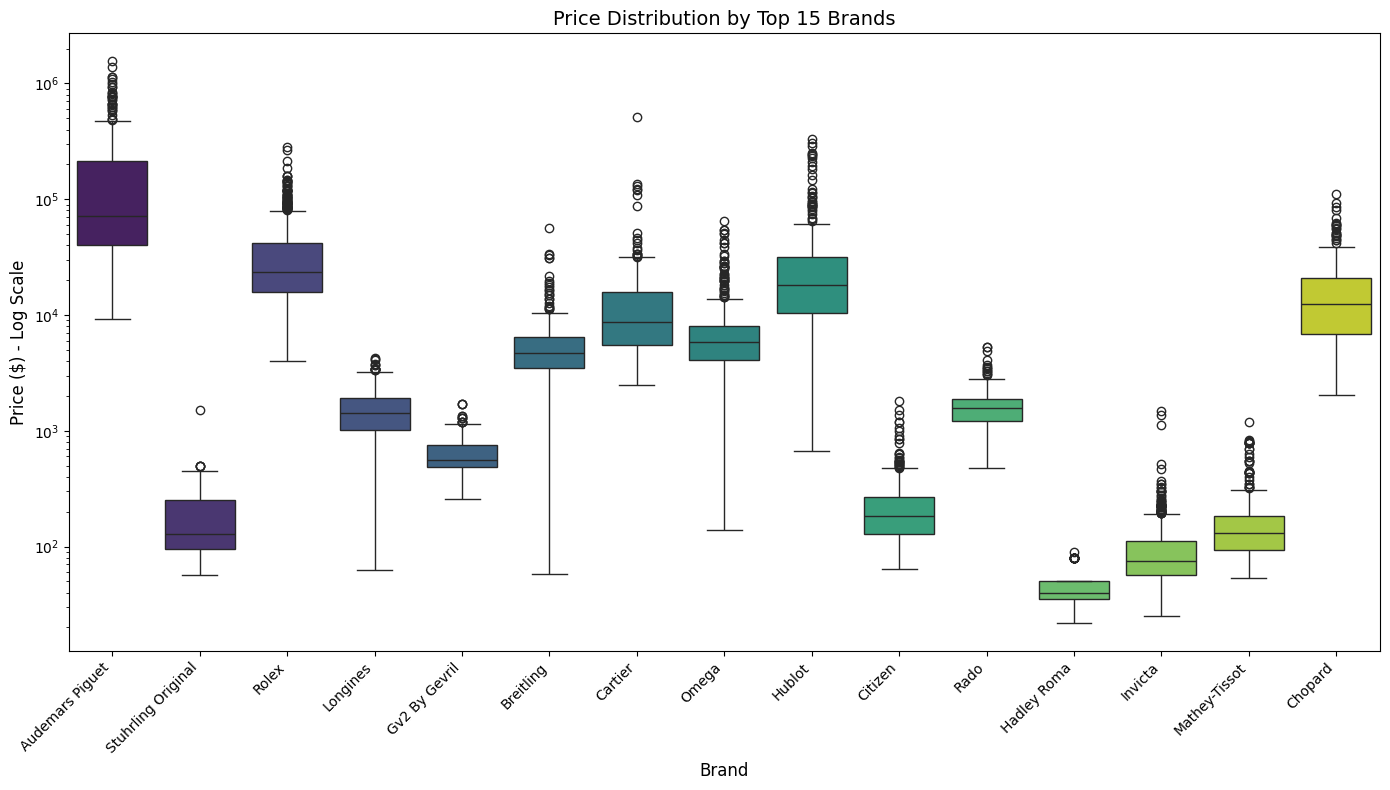

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GENDER', y='Price_Numeric', data=df, palette='viridis')


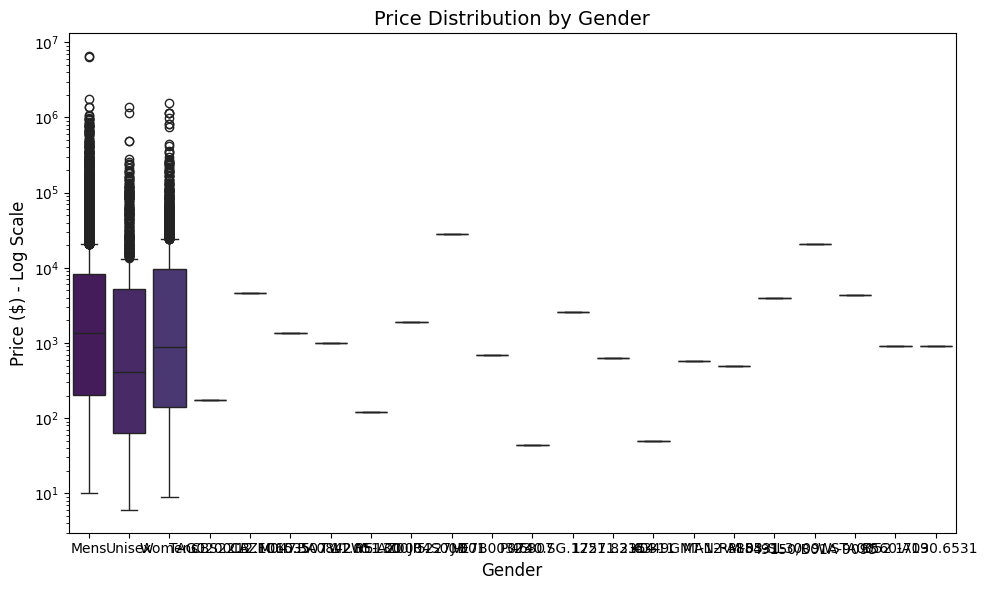

C:\Users\vulin\AppData\Local\Temp\ipykernel_25568\744335811.py:232: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WATCH_STYLE', y='Price_Numeric', data=watch_style_df, palette='viridis')


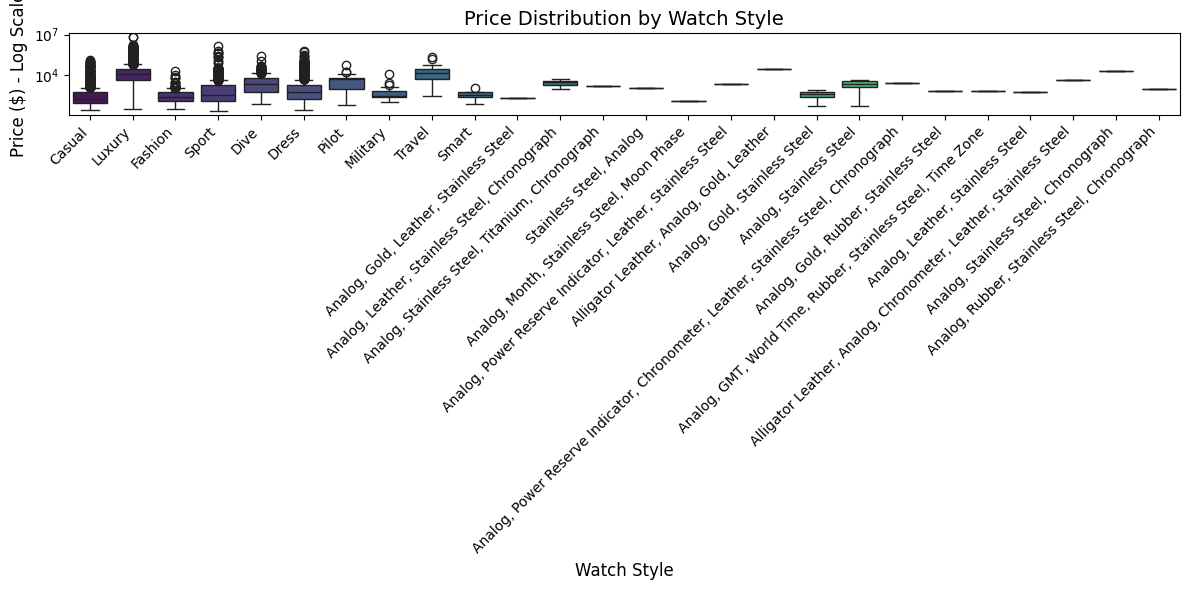

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Read the data (uncomment if you need to load the data again)
# df = pd.read_csv("../data/raw_data.csv")

# Function to display top N values for a column
def plot_top_n_values(dataframe, column, n=10, figsize=(12, 6), min_percentage=1.0):
    """
    Plot a bar chart of the top N most frequent values in a specified column.
    Values representing less than min_percentage % of the data are filtered out.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data
    column : str
        The column name to analyze
    n : int
        Number of top values to display (default: 10)
    figsize : tuple
        Figure size (default: (12, 6))
    min_percentage : float
        Minimum percentage threshold for displaying a value (default: 1.0)
    """
    if column not in dataframe.columns:
        print(f"Column '{column}' not found in the dataframe.")
        return
    
    # Skip if column has all NaN values
    if dataframe[column].isna().all():
        print(f"Column '{column}' contains only NaN values.")
        return
        
    # Count values, excluding NaN
    value_counts = dataframe[column].value_counts()
    
    # Calculate the total count and percentages
    total_count = dataframe[column].count()
    percentages = (value_counts / total_count) * 100
    
    # Filter values that represent at least min_percentage % of the data
    significant_values = value_counts[percentages >= min_percentage]
    
    # Take the top N values from the filtered results
    significant_values = significant_values.head(n)
    
    # If no significant values found
    if len(significant_values) == 0:
        print(f"No values in column '{column}' represent at least {min_percentage}% of the data.")
        return
    
    # Create the plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=significant_values.index, y=significant_values.values, palette="viridis")
    
    # Add count labels on top of bars
    for i, v in enumerate(significant_values.values):
        percentage = percentages.loc[significant_values.index[i]]
        ax.text(i, v + (significant_values.values.max() * 0.02), 
                f"{v:,} ({percentage:.1f}%)", ha='center', fontsize=10)
    
    # Configure the plot
    plt.title(f"Top Values for {column} (≥{min_percentage}%)", fontsize=14)
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Return the value counts for reference
    return significant_values

# Function to visualize missing data
def plot_missing_data(dataframe, figsize=(16, 10)):
    """
    Create a heatmap visualization of missing data.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame to analyze for missing values
    figsize : tuple
        Figure size (default: (16, 10))
    """
    # Calculate percentage of missing values per column
    missing_percentage = dataframe.isna().mean().sort_values(ascending=False) * 100
    
    # Print statistics about missing data
    print(f"Total number of columns: {len(missing_percentage)}")
    print(f"Columns with missing values: {sum(missing_percentage > 0)}")
    print("\nTop 10 columns with highest percentage of missing values:")
    print(missing_percentage.head(10))
    
    # Create a mask for the heatmap (True where data is missing)
    plt.figure(figsize=figsize)
    
    # Only show columns with at least some missing values
    columns_with_missing = missing_percentage[missing_percentage > 0].index.tolist()
    
    if len(columns_with_missing) > 30:
        # If too many columns have missing values, just show top 30
        columns_to_plot = missing_percentage.index[:30]
        plt.title("Missing Data Heatmap (Top 30 Columns with Most Missing Values)", fontsize=16)
    else:
        columns_to_plot = columns_with_missing
        plt.title("Missing Data Heatmap (All Columns with Missing Values)", fontsize=16)
        
    # Create a sample if the dataset is too large
    if len(dataframe) > 1000:
        sample_size = 1000
        sample_df = dataframe.sample(sample_size)
        plt.title(f"Missing Data Heatmap (Sample of {sample_size} Records)", fontsize=16)
    else:
        sample_df = dataframe
    
    # Plot the actual heatmap
    sns.heatmap(
        sample_df[columns_to_plot].isna(), 
        cmap='viridis', 
        cbar_kws={'label': 'Missing Data'},
        yticklabels=False
    )
    
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Records', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Demonstrate with important columns first - Top values
important_columns = ['BRAND', 'MOVEMENT', 'CASE_MATERIAL', 'BAND_MATERIAL', 'GENDER', 'WATCH_STYLE']

for column in important_columns:
    plot_top_n_values(df, column, min_percentage=1.0)  # Only show values that represent at least 1%

# Create missing data visualization
plot_missing_data(df)

# Plot price distribution (after removing '$' and ',' and converting to float)
def extract_price(price_str):
    """
    Extract numeric price value from a string, handling various formats.
    
    Parameters:
    -----------
    price_str : str
        The price string to convert
        
    Returns:
    --------
    float or np.nan
        The extracted price as a float, or np.nan if extraction fails
    """
    if not isinstance(price_str, str):
        return np.nan
    
    try:
        # Remove newlines and tabs first
        price_str = price_str.replace('\r', ' ').replace('\n', ' ').strip()
        
        # Extract the first numeric value with dollar sign and commas
        # This regex finds a dollar sign followed by digits, commas, and decimal point
        match = re.search(r'\$?([\d,]+\.?\d*)', price_str)
        if match:
            # Extract the matched portion and remove commas
            numeric_str = match.group(1).replace(',', '')
            return float(numeric_str)
        return np.nan
    except Exception:
        # Return NaN for any conversion errors
        return np.nan

# Create a price column without the $ and , for analysis
df['Price_Numeric'] = df['Price'].apply(extract_price)

# Display basic statistics about price
print("\nPrice Statistics:")
print(f"Min: ${df['Price_Numeric'].min():,.2f}")
print(f"Max: ${df['Price_Numeric'].max():,.2f}")
print(f"Mean: ${df['Price_Numeric'].mean():,.2f}")
print(f"Median: ${df['Price_Numeric'].median():,.2f}")
print(f"Count: {df['Price_Numeric'].count():,} (out of {len(df):,} records)")

plt.figure(figsize=(12, 6))
ax = sns.histplot(df['Price_Numeric'], bins=50, kde=True)
plt.title('Price Distribution', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(df['Price_Numeric'].median(), color='red', linestyle='--', label=f'Median: ${df["Price_Numeric"].median():,.2f}')
plt.axvline(df['Price_Numeric'].mean(), color='green', linestyle='--', label=f'Mean: ${df["Price_Numeric"].mean():,.2f}')
plt.legend()

# Log scale for better visualization of price distribution
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['Price_Numeric'], bins=50, kde=True, log_scale=True)
plt.title('Price Distribution (Log Scale)', fontsize=14)
plt.xlabel('Price ($) - Log Scale', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Boxplot of prices by brand (top 15 brands)
top_brands = df['BRAND'].value_counts().head(15).index
plt.figure(figsize=(14, 8))
brand_df = df[df['BRAND'].isin(top_brands)]
sns.boxplot(x='BRAND', y='Price_Numeric', data=brand_df, palette='viridis')
plt.title('Price Distribution by Top 15 Brands', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Price ($) - Log Scale', fontsize=12)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplot of prices by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='GENDER', y='Price_Numeric', data=df, palette='viridis')
plt.title('Price Distribution by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Price ($) - Log Scale', fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Boxplot of prices by watch style
plt.figure(figsize=(12, 6))
watch_style_df = df[~df['WATCH_STYLE'].isna()]
sns.boxplot(x='WATCH_STYLE', y='Price_Numeric', data=watch_style_df, palette='viridis')
plt.title('Price Distribution by Watch Style', fontsize=14)
plt.xlabel('Watch Style', fontsize=12)
plt.ylabel('Price ($) - Log Scale', fontsize=12)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()